# Homework 05

The goal of this homework is to familiarize users with monitoring for ML batch services, using PostgreSQL database to store metrics and Grafana to visualize them.

## Import packages

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metrics import *

from joblib import load, dump
from tqdm import tqdm
from pprint import pprint

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Q1. Prepare the dataset

Start with `baseline_model_nyc_taxi_data.ipynb`. Download the March 2024 Green Taxi data. We will use this data to simulate a production usage of a taxi trip duration prediction service.

What is the shape of the downloaded data? How many rows are there?

* 72044
* 78537 
* **57457**
* 54396

In [2]:
# files = [('green_tripdata_2024-03.parquet', './data')]

# print("Download files:")
# for file, path in files:
#     url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
#     resp=requests.get(url, stream=True)
#     save_path=f"{path}/{file}"
#     with open(save_path, "wb") as handle:
#         for data in tqdm(resp.iter_content(),
#                         desc=f"{file}",
#                         postfix=f"save to {save_path}",
#                         total=int(resp.headers["Content-Length"])):
#             handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:03<00:00, 430704.26it/s, save to ./data/green_tripdata_2024-03.parquet]


In [3]:
df = pd.read_parquet(f'./data/green_tripdata_2024-03.parquet')
df.shape

(57457, 20)

### A1: `57457`

## Q2. Metric

Let's expand the number of data quality metrics we’d like to monitor! Please add one metric of your choice and a quantile value for the `"fare_amount"` column (`quantile=0.5`).

Hint: explore evidently metric `ColumnQuantileMetric` (from `evidently.metrics import ColumnQuantileMetric`) 

What metric did you choose?

In [4]:
# data labeling
target = "duration_min"
date_features = ["lpep_pickup_datetime", "lpep_dropoff_datetime"]
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [5]:
df = df[date_features + num_features + cat_features]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57457 entries, 0 to 57456
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   lpep_pickup_datetime   57457 non-null  datetime64[us]
 1   lpep_dropoff_datetime  57457 non-null  datetime64[us]
 2   passenger_count        55360 non-null  float64       
 3   trip_distance          57457 non-null  float64       
 4   fare_amount            57457 non-null  float64       
 5   total_amount           57457 non-null  float64       
 6   PULocationID           57457 non-null  int32         
 7   DOLocationID           57457 non-null  int32         
dtypes: datetime64[us](2), float64(4), int32(2)
memory usage: 3.1 MB


### check date range for pickup

In [11]:
print(f"min_date: {df.lpep_pickup_datetime.min()}")
print(f"max_date: {df.lpep_pickup_datetime.max()}")

min_date: 2024-03-01 00:00:57
max_date: 2024-03-31 23:54:09


### check date range for dropoff

In [12]:
print(f"min_date: {df.lpep_dropoff_datetime.min()}")
print(f"max_date: {df.lpep_dropoff_datetime.max()}")

min_date: 2024-03-01 00:08:23
max_date: 2024-04-01 16:11:00


In [10]:
df = df.loc[(df.lpep_pickup_datetime >= datetime.datetime(2024,3,1,0,0)) & 
                               (df.lpep_pickup_datetime < datetime.datetime(2024,4,1,0,0))]

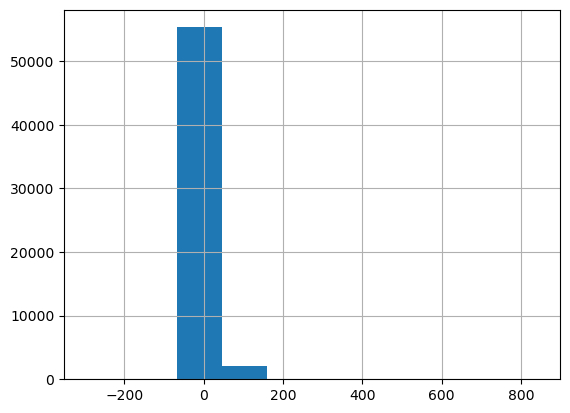

In [17]:
df.fare_amount.hist();

In [23]:
df.fare_amount.describe()

count    57447.000000
mean        17.312937
std         14.956774
min       -295.080000
25%          9.300000
50%         13.500000
75%         19.800000
max        841.600000
Name: fare_amount, dtype: float64

That's a very long tail! Max fare_amount is over $840. And what does it mean some records have *negative* fare_amount?

In [20]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [21]:
report = Report(metrics=[
    ColumnSummaryMetric(column_name='fare_amount'),
    ColumnQuantileMetric(column_name='fare_amount', quantile=0.5),
])

### A2: `ColumnSummaryMetric`

## Q3. Monitoring

Let’s start monitoring. Run expanded monitoring for a new batch of data (March 2024). 

What is the maximum value of metric `quantile = 0.5` on the `"fare_amount"` column during March 2024 (calculated daily)?

* 10
* 12.5
* **14.2**
* 14.8

In [59]:
quantile_df = pd.DataFrame()

def generate_daily_reports(df, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date)

    for single_date in date_range:
        day_data = df[df['lpep_pickup_datetime'].dt.date == single_date.date()]
        # display(day_data)

        if day_data.empty:
            continue
        
        # Generate the Evidently report for the day
        daily_report = Report(
            metrics=[
                ColumnSummaryMetric(column_name='fare_amount'),
                ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
            ],
            timestamp=single_date
        )
        
        daily_report.run(reference_data=None, current_data=day_data)
        # print()
        # Extract the quantile result
        quantile_result = daily_report.as_dict()

        print(
            single_date.date(), 
            quantile_result['metrics'][0]['result']['current_characteristics']['mean'],
            quantile_result['metrics'][1]['result']['current']['value']
        )

    # return pd.concat([quantile_df, daily], axis =0).reset_index()

In [60]:
# Define the date range for the reports
start_date = df['lpep_pickup_datetime'].min().date()
end_date = df['lpep_pickup_datetime'].max().date()

generate_daily_reports(df, start_date, end_date)

2024-03-01 16.85 13.5
2024-03-02 17.58 13.5
2024-03-03 18.56 14.2
2024-03-04 16.4 12.8
2024-03-05 17.22 13.5
2024-03-06 16.18 12.8
2024-03-07 17.85 13.5
2024-03-08 17.05 13.5
2024-03-09 17.45 13.5
2024-03-10 18.08 14.2
2024-03-11 16.51 12.8
2024-03-12 17.27 13.5
2024-03-13 17.01 13.5
2024-03-14 18.0 14.2
2024-03-15 17.41 13.5
2024-03-16 18.23 14.2
2024-03-17 17.99 13.5
2024-03-18 16.73 13.5
2024-03-19 17.41 13.5
2024-03-20 16.58 12.8
2024-03-21 17.01 13.5
2024-03-22 17.44 13.5
2024-03-23 17.0 12.8
2024-03-24 18.59 14.2
2024-03-25 17.28 13.5
2024-03-26 17.41 13.5
2024-03-27 16.91 13.5
2024-03-28 16.94 13.5
2024-03-29 17.24 13.5
2024-03-30 18.26 14.2
2024-03-31 17.97 13.5


### A3: `14.2`

## Q4. Dashboard


Finally, let’s add panels with new added metrics to the dashboard. After we customize the  dashboard let's save a dashboard config, so that we can access it later. Hint: click on “Save dashboard” to access JSON configuration of the dashboard. This configuration should be saved locally.

Where to place a dashboard config file?

* `project_folder` (05-monitoring)
* **`project_folder/config`  (05-monitoring/config)**
* `project_folder/dashboards`  (05-monitoring/dashboards)
* `project_folder/data`  (05-monitoring/data)

### A4: `'project_folder/config'  (05-monitoring/config)`

### below section still not working

### create dashboard

In [48]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

### create workspace

In [49]:
ws = Workspace("workspace")

### create project

In [53]:
project = ws.create_project("NYC Taxi Homework 5")
project.description = "Homework 5 project desc"
project.save()

Project(id=UUID('8b2a48ad-4809-4d00-b54e-53a80f61f766'), name='NYC Taxi Homework 5', description='Homework 5 project desc', dashboard=DashboardConfig(name='NYC Taxi Homework 5', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 6, 25, 11, 11, 10, 195113))

### configure dashboard panels

In [51]:
#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi homework 5 dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('2ac44a1e-bedd-4d4c-b155-ddf56dc8a7af'), name='NYC Taxi Data Quality Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[DashboardPanelCounter(type='evidently.ui.dashboards.reports.DashboardPanelCounter', id=UUID('316d8c23-5a5f-435b-b234-a46658ca9c13'), title='NYC taxi data dashboard', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text=None), DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('456f3cc1-d756-48da-97ab-772f28b35e61'), title='Inference Count', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.number_of_rows', metric_id='DatasetSummaryMetric', metric_fingerprint=None, metric_args={}, legend='count')], plot_type=<PlotType.BAR: 'bar'>), DashboardPanelPlot(